In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
import plotly.express as px
import dask.dataframe as dd
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules
import matplotlib.colors as mcolors

In [3]:
orders = pd.read_csv('orders.csv')
products = pd.read_csv('products.csv')
order_products = pd.read_csv('order_products__train.csv')
order_products_prior = pd.read_csv('order_products__prior.csv')
aisles = pd.read_csv('aisles.csv')
departments = pd.read_csv('departments.csv')

In [4]:
print("Orders:")
display(orders.head())
print("\nOrder Products:")
display(order_products.head())
print("\nProducts:")
display(products.head())
print("\nAisles:")
display(aisles.head())
print("\nDepartments:")
display(departments.head())

Orders:


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0


Order Products:


order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1


Products:


product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13


Aisles:


aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation


Departments:


department_id department
0              1     frozen
1              2      other
2              3     bakery
3              4    produce
4              5    alcohol

# High Level Overview

In [5]:
print("Number of Users : ",orders['user_id'].nunique())
print("Number of Orders : ",orders['user_id'].count())
print("Number of Aisles : ",aisles['aisle'].nunique())
print("Number of Departments : ",departments['department'].nunique())

Number of Users :  206209
Number of Orders :  3421083
Number of Aisles :  134
Number of Departments :  21


In [6]:
most_num_orders = orders.groupby('user_id')['order_id'].count().reset_index().sort_values(by = 'order_id',ascending = False).nlargest(1,columns='order_id',keep='all')

In [7]:
most_num_orders

user_id  order_id
152339   152340       100
185640   185641       100
185523   185524       100
81677     81678       100
70921     70922       100
...         ...       ...
126847   126848       100
66997     66998       100
128799   128800       100
124822   124823       100
94700     94701       100

[1374 rows x 2 columns]

In [8]:
order_products.head()

order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1

In [9]:
orders.head()

order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0

In [10]:
order_merge = order_products.merge(orders, on=['order_id'], how='inner')

In [11]:
order_merge.columns
order_merge.drop(columns = ['eval_set'],inplace = True)

In [12]:
cart_size = order_merge['add_to_cart_order'].value_counts().reset_index().rename(columns = {'index':'cart_size','add_to_cart_order':'Count'})

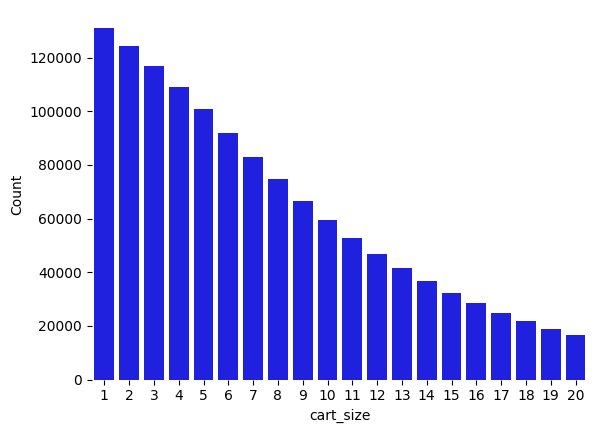

In [13]:
sns.barplot(data = cart_size[:20], x = 'cart_size', y = 'Count',color = 'blue')
sns.despine(left = True, bottom = True)
plt.show()

In [14]:
df_merged = order_products.merge(orders, on=['order_id'], how='inner')
df_merged = df_merged.merge(products,on='product_id',how='inner')
df_merged.head()

order_id  product_id  add_to_cart_order  reordered  user_id eval_set  \
0         1       49302                  1          1   112108    train   
1    816049       49302                  7          1    47901    train   
2   1242203       49302                  1          1     2993    train   
3   1383349       49302                 11          1    41425    train   
4   1787378       49302                  8          0   187205    train   

   order_number  order_dow  order_hour_of_day  days_since_prior_order  \
0             4          4                 10                     9.0   
1            14          4                  6                    16.0   
2            15          0                  7                     7.0   
3             4          3                  8                    14.0   
4             5          4                 14                    30.0   

       product_name  aisle_id  department_id  
0  Bulgarian Yogurt       120             16  
1  Bulgarian Yogurt       120             16  
2  Bulgarian Yogurt       120             16  
3  Bulgarian Yogurt       120             16  
4  Bulgarian Yogurt       120             16

In [15]:
order_products = pd.concat([order_products_prior, order_products])
order_products = order_products.merge(orders[['order_id', 'user_id', 'order_number']], on='order_id')
top_products = order_products.groupby('product_id').size().reset_index(name='n').sort_values('n', ascending=False).head(2000)

top_distributions = (order_products[order_products['product_id'].isin(top_products['product_id'])]
    .merge(orders[['order_id', 'order_hour_of_day']], on='order_id')
    .groupby(['product_id', 'order_hour_of_day'])
    .size()
    .reset_index(name='n')
    .merge(products[['product_id', 'product_name']], on='product_id')
)

top_distributions['pct'] = top_distributions.groupby('product_id')['n'].transform(lambda x: x / x.sum() * 100)

top_stats = (top_distributions.groupby(['product_id', 'product_name'])
    .apply(lambda x: pd.Series({'mean_hour': (x['order_hour_of_day'] * x['n']).sum() / x['n'].sum()}))
    .reset_index()
)

products_per_group = 25

morning = top_stats.nsmallest(products_per_group, 'mean_hour')
late = top_stats.nlargest(products_per_group, 'mean_hour')
morning_names = '\n'.join(morning['product_name'])
late_names = '\n'.join(late['product_name'])

top_distributions['hour_group'] = top_distributions['product_id'].apply(
    lambda x: 'morning' if x in morning['product_id'].values else 'late' if x in late['product_id'].values else None
)
filtered_distributions = top_distributions.dropna(subset=['hour_group'])

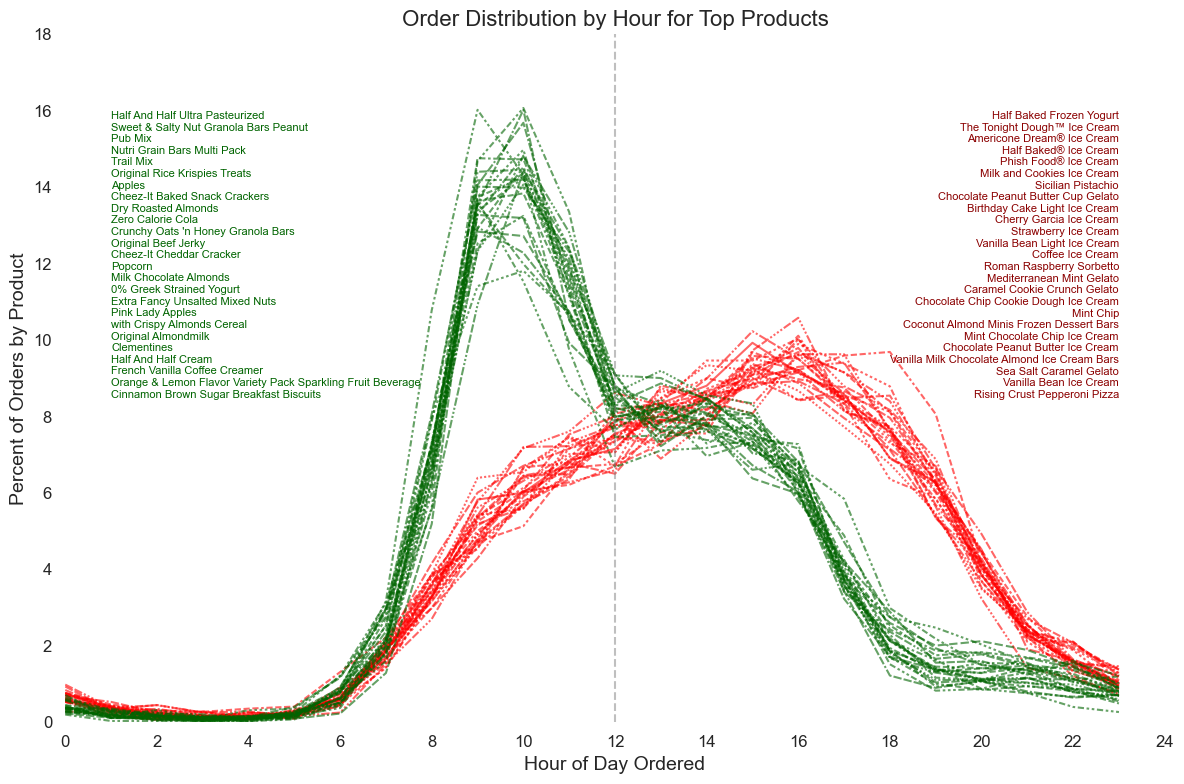

In [16]:
plt.figure(figsize=(12, 8))
sns.set(style="whitegrid")

sns.lineplot(
    data=filtered_distributions, 
    x='order_hour_of_day', 
    y='pct', 
    hue='hour_group', 
    style='product_name', 
    palette={'morning': 'darkgreen', 'late': 'red'}, 
    legend=False, 
    linewidth=1.5, 
    alpha=0.6
)

plt.axvline(12, color='gray', linestyle='--', alpha=0.5)

plt.text(1, 16, morning_names, ha='left', va='top', size=8, color='darkgreen', wrap=True)
plt.text(23, 16, late_names, ha='right', va='top', size=8, color='darkred', wrap=True)

plt.xlabel('Hour of Day Ordered', fontsize=14)
plt.ylabel('Percent of Orders by Product', fontsize=14)
plt.title('Order Distribution by Hour for Top Products', fontsize=16)
plt.xlim(0, 24)
plt.ylim(0, 18)
plt.xticks(range(0, 25, 2), fontsize=12)
plt.yticks(fontsize=12)
plt.grid(False)
plt.tight_layout()
sns.despine(bottom = True, left = True)

plt.show()

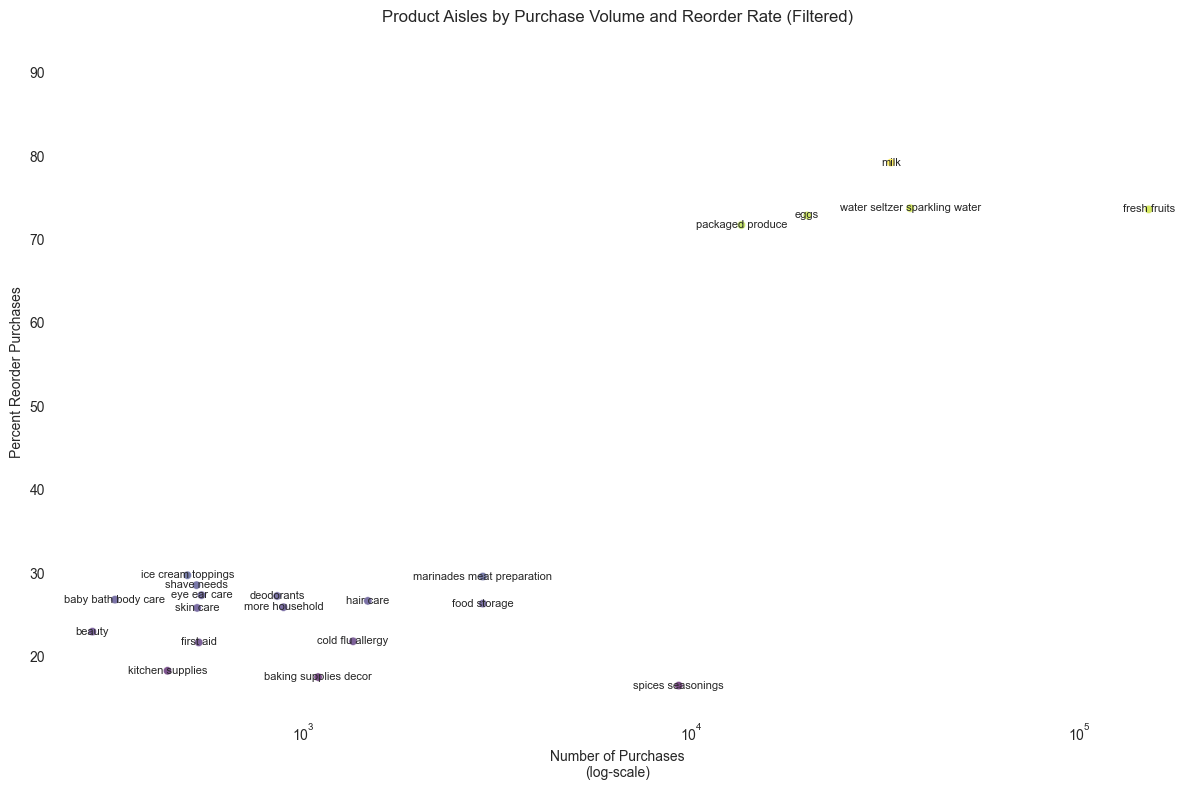

In [74]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# merged_data = order_products.merge(products, on='product_id')
# merged_data = merged_data.merge(aisles, on='aisle_id')
# merged_data = merged_data.merge(departments, on='department_id')

# aisle_stats = merged_data.groupby('aisle').agg({
#     'order_id': 'count',
#     'reordered': 'mean'
# }).reset_index()

# aisle_stats.columns = ['aisle', 'purchases', 'reorder_percent']
# aisle_stats['reorder_percent'] *= 100  

# filtered_aisle_stats = aisle_stats[(aisle_stats['reorder_percent'] < 30) | (aisle_stats['reorder_percent'] > 70)]

# plt.figure(figsize=(12, 8))
# sns.set_style("white")  

# scatter = sns.scatterplot(
#     x='purchases', 
#     y='reorder_percent', 
#     hue='reorder_percent', 
#     data=filtered_aisle_stats, 
#     palette="viridis", 
#     legend=None,
#     alpha=0.7
# )

# for idx, row in filtered_aisle_stats.iterrows():
#     plt.text(row['purchases'], row['reorder_percent'], row['aisle'], 
#              fontsize=8, ha='center', va='center')

# plt.xscale('log')
# plt.xlabel('Number of Purchases\n(log-scale)')
# plt.ylabel('Percent Reorder Purchases')
# plt.title('Product Aisles by Purchase Volume and Reorder Rate (Filtered)')

# plt.xlim(filtered_aisle_stats['purchases'].min() * 0.8, filtered_aisle_stats['purchases'].max() * 1.2)
# plt.ylim(filtered_aisle_stats['reorder_percent'].min() * 0.8, filtered_aisle_stats['reorder_percent'].max() * 1.2)

# plt.gca().grid(False)

# plt.tight_layout()
# sns.despine(bottom = True, left = True)
# plt.show()

findfont: Font family ['cmsy10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmr10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmtt10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmmi10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmb10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmss10'] not found. Falling back to DejaVu Sans.
findfont: Font family ['cmex10'] not found. Falling back to DejaVu Sans.


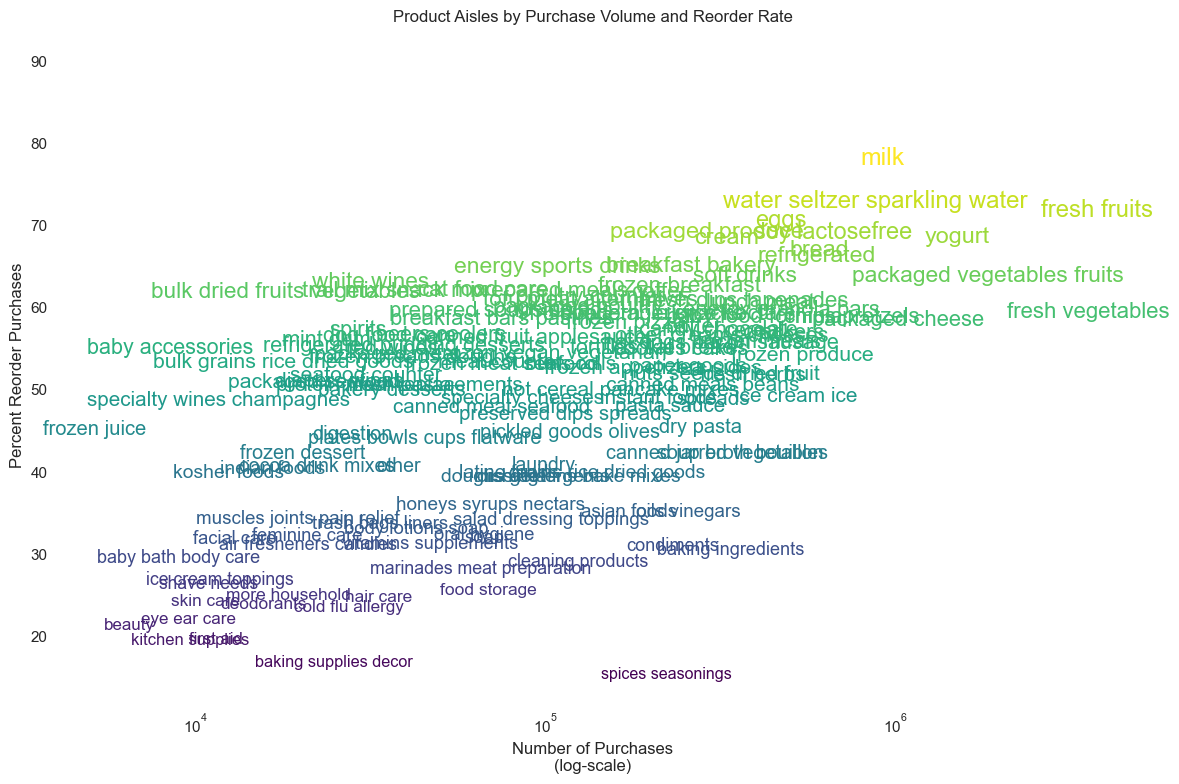

In [20]:
merged_data = order_products.merge(products, on='product_id')
merged_data = merged_data.merge(aisles, on='aisle_id')
merged_data = merged_data.merge(departments, on='department_id')

aisle_stats = merged_data.groupby('aisle').agg({
    'order_id': 'count',
    'reordered': 'mean'
}).reset_index()

aisle_stats.columns = ['aisle', 'purchases', 'reorder_percent']
aisle_stats['reorder_percent'] *= 100  

plt.figure(figsize=(12, 8))
sns.set_style("white")  

norm = mcolors.Normalize(vmin=aisle_stats['reorder_percent'].min(), vmax=aisle_stats['reorder_percent'].max())
cmap = plt.get_cmap('viridis')

for idx, row in aisle_stats.iterrows():
    plt.text(
        row['purchases'], 
        row['reorder_percent'], 
        row['aisle'], 
        fontsize=10 + row['reorder_percent'] / 10,  
        color=cmap(norm(row['reorder_percent'])),  
        ha='center', 
        va='center'
    )

plt.xscale('log')
plt.xlabel('Number of Purchases\n(log-scale)')
plt.ylabel('Percent Reorder Purchases')
plt.title('Product Aisles by Purchase Volume and Reorder Rate')

plt.xlim(aisle_stats['purchases'].min() * 0.8, aisle_stats['purchases'].max() * 1.2)
plt.ylim(aisle_stats['reorder_percent'].min() * 0.8, aisle_stats['reorder_percent'].max() * 1.2)

plt.gca().grid(False)

sns.despine(bottom = True, left = True)
plt.tight_layout()
plt.show()

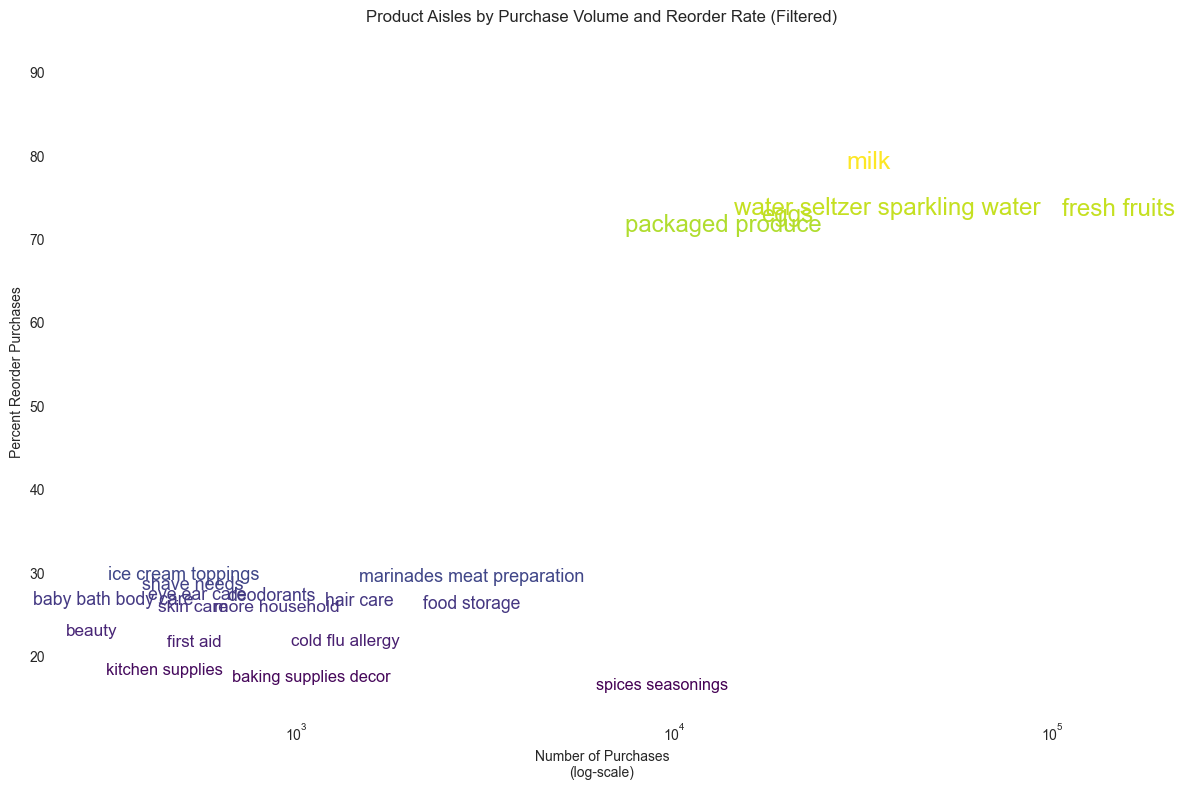

In [77]:
aisle_stats = merged_data.groupby('aisle').agg({
    'order_id': 'count',
    'reordered': 'mean'
}).reset_index()

aisle_stats.columns = ['aisle', 'purchases', 'reorder_percent']
aisle_stats['reorder_percent'] *= 100  

filtered_aisle_stats = aisle_stats[(aisle_stats['reorder_percent'] < 30) | (aisle_stats['reorder_percent'] > 70)]

plt.figure(figsize=(12, 8))
sns.set_style("white")  

norm = mcolors.Normalize(vmin=filtered_aisle_stats['reorder_percent'].min(), vmax=filtered_aisle_stats['reorder_percent'].max())
cmap = plt.get_cmap('viridis')

for idx, row in filtered_aisle_stats.iterrows():
    plt.text(
        row['purchases'], 
        row['reorder_percent'], 
        row['aisle'], 
        fontsize=10 + row['reorder_percent'] / 10,  
        color=cmap(norm(row['reorder_percent'])),  
        ha='center', 
        va='center'
    )

plt.xscale('log')
plt.xlabel('Number of Purchases\n(log-scale)')
plt.ylabel('Percent Reorder Purchases')
plt.title('Product Aisles by Purchase Volume and Reorder Rate (Filtered)')

plt.xlim(filtered_aisle_stats['purchases'].min() * 0.8, filtered_aisle_stats['purchases'].max() * 1.2)
plt.ylim(filtered_aisle_stats['reorder_percent'].min() * 0.8, filtered_aisle_stats['reorder_percent'].max() * 1.2)

plt.gca().grid(False)

sns.despine(bottom = True, left = True)
plt.tight_layout()
plt.show()

In [24]:
department_stats = merged_data.groupby('department').agg({
    'order_id': 'count',
    'reordered': 'mean'
}).reset_index()
department_stats.columns = ['department', 'purchases', 'reorder_percent']
department_stats['reorder_percent'] *= 100  

In [22]:
department_stats = merged_data.groupby('department').agg({
    'order_id': 'count',
    'reordered': 'sum'
}).reset_index()
department_stats.columns = ['department', 'purchases', 'reorder_cnt']
department_stats['reorder_cnt']/department_stats['purchases']

0     0.571221
1     0.577680
2     0.628381
3     0.653651
4     0.561351
5     0.577090
6     0.458639
7     0.670161
8     0.608130
9     0.462220
10    0.542634
11    0.403339
12    0.369682
13    0.568625
14    0.394323
15    0.407052
16    0.347400
17    0.321863
18    0.602557
19    0.650521
20    0.574464
dtype: float64

In [25]:
department_stats.sort_values(by ='reorder_percent',ascending = False)

department  purchases  reorder_percent
7        dairy eggs    5631067        67.016127
3         beverages    2804175        65.365107
19          produce    9888378        65.052084
2            bakery    1225181        62.838062
8              deli    1095540        60.813024
18             pets     102221        60.255720
1            babies     438743        57.767987
5              bulk      35932        57.709006
20           snacks    3006412        57.446385
0           alcohol     159294        57.122051
13     meat seafood     739238        56.862472
4         breakfast     739069        56.135083
10           frozen    2336858        54.263374
9   dry goods pasta     905340        46.221972
6      canned goods    1114857        45.863909
15            other      38086        40.705246
11        household     774652        40.333853
14          missing      77396        39.432270
12    international     281155        36.968220
16           pantry    1956819        34.740004
17    personal care     468693        32.186314

In [26]:
aisle_stats.sort_values(by = 'reorder_percent',ascending = False)

aisle  purchases  reorder_percent
83                            milk     923659        78.181234
131  water seltzer sparkling water     878150        72.992997
50                    fresh fruits    3792661        71.882275
41                            eggs     472009        70.635941
119                soy lactosefree     664493        69.236094
..                             ...        ...              ...
8                           beauty       6455        21.285825
47                       first aid      11411        19.586364
76                kitchen supplies       9620        19.480249
7            baking supplies decor      24786        16.759461
122              spices seasonings     221371        15.293331

[134 rows x 3 columns]

In [33]:
order_merge.groupby('user_id')['order_id'].count().reset_index().sort_values(by = 'order_id',ascending = False).nlargest(1,columns='order_id',keep='all')

user_id  order_id
95198    149753        80
125721   197541        80

In [27]:
order_products_prior = order_products_prior.rename(columns={'reordered': 'reordered_prior'})
order_products = order_products.rename(columns={'reordered': 'reordered_curr'})

df = order_products_prior.merge(order_products, on=['product_id', 'order_id'], how='outer')
df = df.merge(products, on='product_id')
df = df.merge(departments, on='department_id')
df = df.merge(aisles, on='aisle_id')

# 1: Count of products reordered in both quarters
query1_result = df[(df['reordered_prior'] == 1) & (df['reordered_curr'] == 1)]['product_id'].nunique()
print("Count of products reordered in both quarters:", query1_result)

# 2: Count of reordered products in Q3 and Q4
query2_result_curr = df[df['reordered_curr'] == 1]['product_id'].count()
query2_result_prior = df[df['reordered_prior'] == 1]['product_id'].count()
print("Count of reordered products in current quarter:", query2_result_curr)
print("Count of reordered products in prior quarter:", query2_result_prior)

# 3: Difference in product count by department
curr_cnt = df.groupby('department')['product_id'].count().reset_index(name='cnt_over_dept_curr')
prior_cnt = df.groupby('department')['product_id'].count().reset_index(name='cnt_over_dept_prior')
query3_result = curr_cnt.merge(prior_cnt, on='department')
query3_result['diff'] = query3_result['cnt_over_dept_curr'] - query3_result['cnt_over_dept_prior']
query3_result = query3_result[['department', 'diff']].sort_values('diff', ascending=False)
print("\nDifference in product count by department:")
print(query3_result)

# 4: Amount of reorders by aisle
query4_result = df.groupby(['aisle_id', 'aisle']).agg({
    'reordered_prior': 'sum',
    'reordered_curr': 'sum'
}).reset_index()
query4_result = query4_result.rename(columns={
    'reordered_prior': 'prior_reorders',
    'reordered_curr': 'current_reorders'
})
query4_result = query4_result.sort_values('current_reorders', ascending=False)
print("\nAmount of reorders by aisle:")
print(query4_result)

# 5: Amount of reorders by department
query5_result = df.groupby(['department_id', 'department']).agg({
    'reordered_prior': 'sum',
    'reordered_curr': 'sum'
}).reset_index()
query5_result = query5_result.rename(columns={
    'reordered_prior': 'prior_reorders',
    'reordered_curr': 'current_reorders'
})
query5_result = query5_result.sort_values('current_reorders', ascending=False)
print("\nAmount of reorders by department:")
print(query5_result)

Count of products reordered in both quarters: 45305
Count of reordered products in current quarter: 19955360
Count of reordered products in prior quarter: 19126536

Difference in product count by department:
         department  diff
0           alcohol     0
11        household     0
19          produce     0
18             pets     0
17    personal care     0
16           pantry     0
15            other     0
14          missing     0
13     meat seafood     0
12    international     0
10           frozen     0
1            babies     0
9   dry goods pasta     0
8              deli     0
7        dairy eggs     0
6      canned goods     0
5              bulk     0
4         breakfast     0
3         beverages     0
2            bakery     0
20           snacks     0

Amount of reorders by aisle:
     aisle_id                       aisle  prior_reorders  current_reorders
23         24                fresh fruits       2615469.0           2726251
82         83            fresh vegetab

In [31]:
order_products_prior = order_products_prior.rename(columns={'reordered': 'reordered_prior'})
order_products = order_products.rename(columns={'reordered': 'reordered_curr'})

df = products.merge(order_products_prior, on='product_id', how='left')
df = df.merge(order_products, on='product_id', how='left')
df = df.merge(departments, on='department_id')
df = df.merge(aisles, on='aisle_id')

result = df.groupby(['product_id', 'product_name', 'aisle_id', 'department_id', 'department', 'aisle']).agg({
    'reordered_prior': 'sum',
    'reordered_curr': 'sum'
}).reset_index()

result = result.rename(columns={
    'reordered_prior': 'prior_reorders',
    'reordered_curr': 'current_reorders'
})

result = result[(result['prior_reorders'] < 10) & (result['current_reorders'] >= 10)]

result = result.sort_values('current_reorders', ascending=False)

print("Trending Products (increased from <10 to >=10 reorders):")
print(result.head(20))  

print("\nNumber of trending products:", len(result))

print("\nTop 5 departments with trending products:")
print(result['department'].value_counts().head())

print("\nTop 5 aisles with trending products:")
print(result['aisle'].value_counts().head())

In [5]:
orders['order_hour_of_day'] = pd.to_numeric(orders['order_hour_of_day'])
orders['eval_set'] = orders['eval_set'].astype('category')
products['product_name'] = products['product_name'].astype('category')
aisles['aisle'] = aisles['aisle'].astype('category')
departments['department'] = departments['department'].astype('category')

# When do people order?

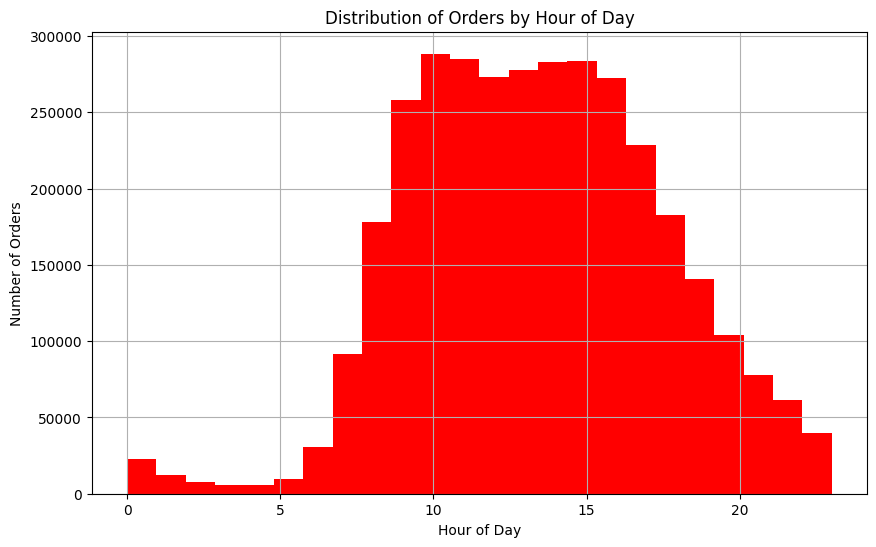

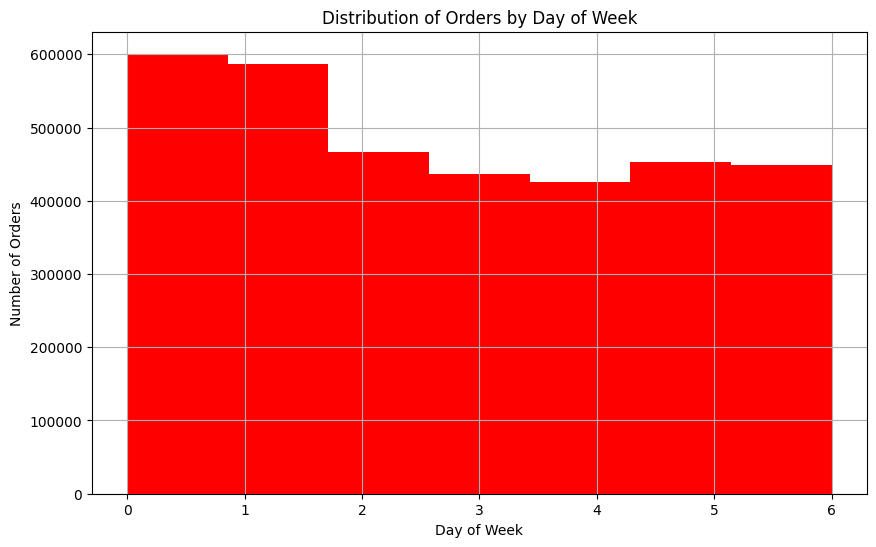

In [6]:
plt.figure(figsize=(10, 6))
orders['order_hour_of_day'].hist(bins=24, color='red')
plt.title('Distribution of Orders by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Orders')
plt.show()

plt.figure(figsize=(10, 6))
orders['order_dow'].hist(bins=7, color='red')
plt.title('Distribution of Orders by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Number of Orders')
plt.show()

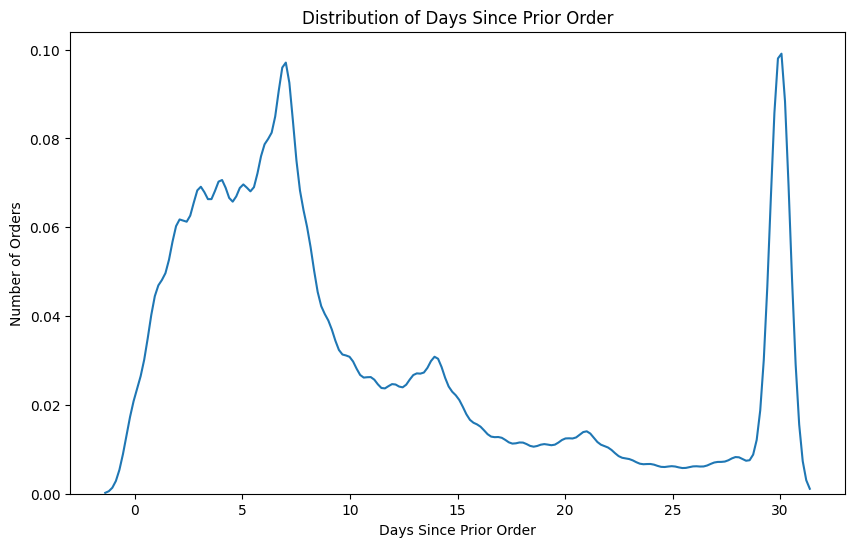

In [37]:
# When do they order again?
plt.figure(figsize=(10, 6))
sns.kdeplot(data = orders['days_since_prior_order'])
plt.title('Distribution of Days Since Prior Order')
plt.xlabel('Days Since Prior Order')
plt.ylabel('Number of Orders')
plt.show()

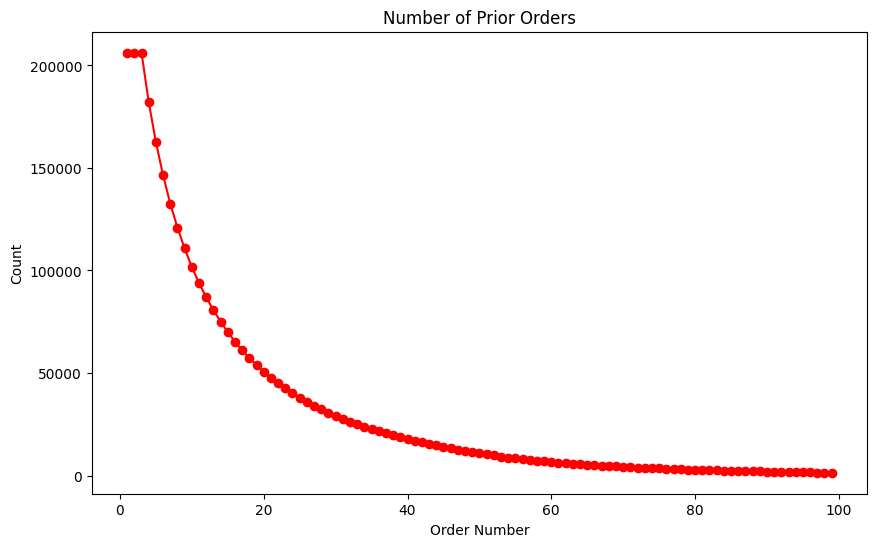

In [8]:
# How many prior orders are there?
prior_orders = orders[orders['eval_set'] == 'prior']
order_counts = prior_orders['order_number'].value_counts().sort_index()
plt.figure(figsize=(10, 6))
plt.plot(order_counts.index, order_counts.values, color='red', marker='o')
plt.title('Number of Prior Orders')
plt.xlabel('Order Number')
plt.ylabel('Count')
plt.show()

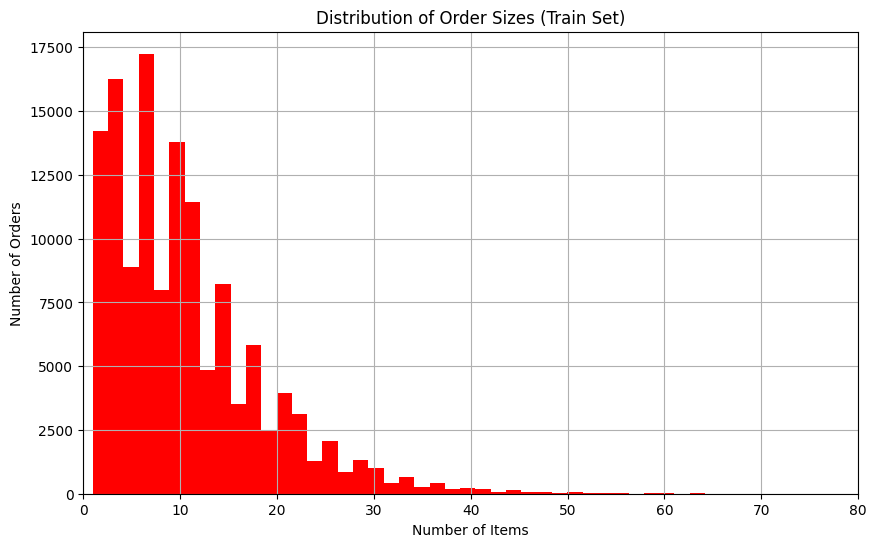

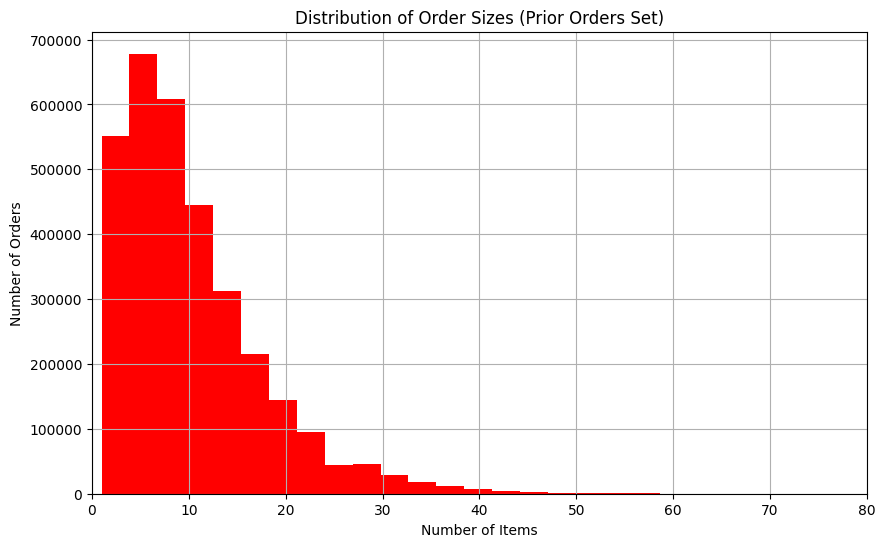

In [9]:
# How many items do people buy?
def plot_order_sizes(data, title):
    order_sizes = data.groupby('order_id')['add_to_cart_order'].max()
    plt.figure(figsize=(10, 6))
    order_sizes.hist(bins=50, color='red')
    plt.title(title)
    plt.xlabel('Number of Items')
    plt.ylabel('Number of Orders')
    plt.xlim(0, 80)
    plt.show()

plot_order_sizes(order_products, 'Distribution of Order Sizes (Train Set)')
plot_order_sizes(order_products_prior, 'Distribution of Order Sizes (Prior Orders Set)')

Top 10 Bestsellers:


product_id  count            product_name
0       24852  18726                  Banana
1       13176  15480  Bag of Organic Bananas
2       21137  10894    Organic Strawberries
3       21903   9784    Organic Baby Spinach
4       47626   8135             Large Lemon
5       47766   7409         Organic Avocado
6       47209   7293    Organic Hass Avocado
7       16797   6494            Strawberries
8       26209   6033                   Limes
9       27966   5546     Organic Raspberries

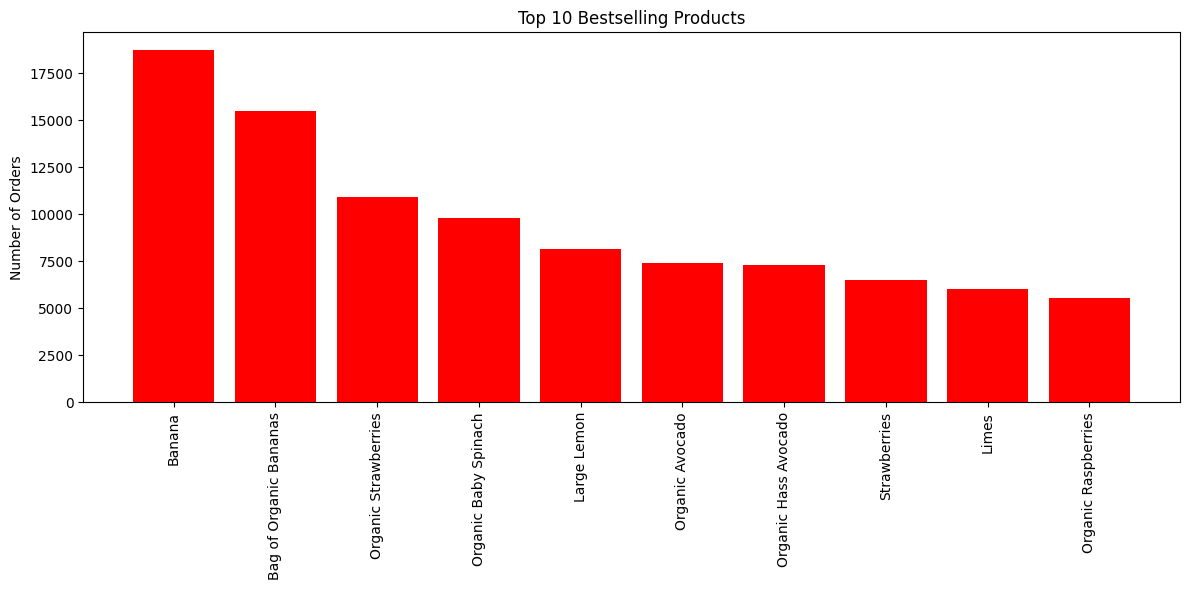

In [10]:
# Bestsellers
bestsellers = order_products.groupby('product_id').size().nlargest(10).reset_index(name='count')
bestsellers = bestsellers.merge(products[['product_id', 'product_name']], on='product_id')
bestsellers = bestsellers.sort_values('count', ascending=False)
print("Top 10 Bestsellers:")
display(bestsellers)

plt.figure(figsize=(12, 6))
plt.bar(bestsellers['product_name'], bestsellers['count'], color='red')
plt.title('Top 10 Bestselling Products')
plt.xticks(rotation=90)
plt.ylabel('Number of Orders')
plt.tight_layout()
plt.show()

In [38]:
# Lowest Selling Items
least_selling = order_products.groupby('product_id').size().reset_index(name='count')
least_selling = least_selling.merge(products[['product_id', 'product_name']], on='product_id')
least_selling = least_selling[least_selling['count']==least_selling['count'].min()]
print("Least Selling Items:")
display(least_selling)

# plt.figure(figsize=(12, 6))
# plt.bar(least_selling['product_name'], least_selling['count'], color='red')
# plt.title('Bottom 10 Products')
# plt.xticks(rotation=90)
# plt.ylabel('Number of Orders')
# plt.tight_layout()
# plt.show()

Least Selling Items:


product_id  count                                product_name
4               5      1                   Green Chile Anytime Sauce
5               7      1              Pure Coconut Water With Orange
11             13      1                           Saline Nasal Mist
12             14      1              Fresh Scent Dishwasher Cleaner
14             16      1               Mint Chocolate Flavored Syrup
...           ...    ...                                         ...
39100       49658      1                  Brie with Herbs Foil Wedge
39102       49662      1                Bacon Cheddar Pretzel Pieces
39108       49671      1                        Milk Chocolate Drops
39109       49672      1                      Cafe Mocha K-Cup Packs
39121       49687      1  Smartblend Healthy Metabolism Dry Cat Food

[7884 rows x 3 columns]

In [25]:
product_counts = order_products.groupby('product_id').size().reset_index(name = "Count").sort_values(by = 'Count',ascending = False)

In [34]:
print("Average Product Sales : ",product_counts['Count'].mean())
print("Percentage of Products with more than the average Sales : ",100.0*product_counts[product_counts['Count']>product_counts['Count'].mean()]['product_id'].count()/product_counts['product_id'].count())

Average Product Sales :  35.39138102906219
Percentage of Products with more than the average Sales :  15.205889118932598


Reorder Proportions:


0    0.401406
1    0.598594
Name: reordered, dtype: float64

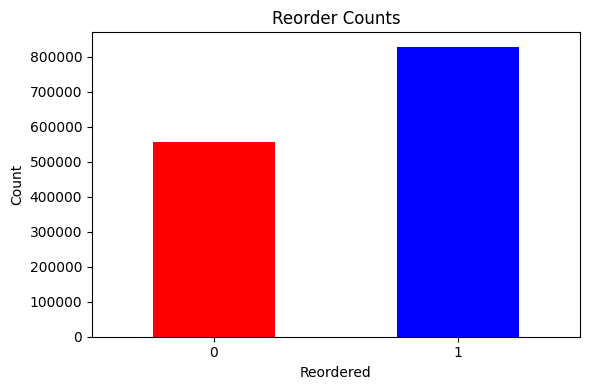

In [11]:
# How often do people order the same items again?
reorder_counts = order_products['reordered'].value_counts().sort_index()
reorder_proportions = reorder_counts / reorder_counts.sum()
print("Reorder Proportions:")
display(reorder_proportions)

plt.figure(figsize=(6, 4))
reorder_counts.plot(kind='bar', color=['red', 'blue'])
plt.title('Reorder Counts')
plt.xlabel('Reordered')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [40]:
# Visualizing the Product Portfolio
product_hierarchy = products.groupby(['department_id', 'aisle_id']).size().reset_index(name='product_count')
product_hierarchy = product_hierarchy.merge(departments, on='department_id').merge(aisles, on='aisle_id')

product_sales = order_products.groupby('product_id').size().reset_index(name='sales_count')
product_sales = product_sales.merge(products[['product_id', 'department_id', 'aisle_id']], on='product_id')
sales_hierarchy = product_sales.groupby(['department_id', 'aisle_id'])['sales_count'].sum().reset_index()
sales_hierarchy = sales_hierarchy.merge(product_hierarchy, on=['department_id', 'aisle_id'])

def create_treemap(data, values, title):
    fig = px.treemap(data, 
                     path=['department', 'aisle'], 
                     values=values,
                     title=title,
                     color='department',
                     color_continuous_scale='RdBu')
    fig.update_layout(margin = dict(t=50, l=25, r=25, b=25))
    fig.show()

create_treemap(product_hierarchy, 'product_count', 'Product Portfolio: Number of Unique Products')
create_treemap(sales_hierarchy, 'sales_count', 'Product Portfolio: Number of Sales')

In [33]:
df = order_products.merge(orders[['order_id', 'user_id']], on='order_id')
df = df.merge(products[['product_id', 'product_name']], on='product_id')

basket = pd.crosstab(df['order_id'], df['product_name'])

frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)

rules = rules.sort_values('lift', ascending=False)

rules.head(10)

In [35]:
plt.figure(figsize=(10, 8))
plt.scatter(rules['support'], rules['confidence'], alpha=0.5, s=rules['lift']*20)
plt.xlabel('Support')
plt.ylabel('Confidence')
plt.title('Top 20 Association Rules')

for i, rule in rules.head(20).iterrows():
    plt.annotate(f"{rule['antecedents']} -> {rule['consequents']}", 
                 (rule['support'], rule['confidence']))
plt.tight_layout()
plt.show()

In [36]:
print("1. Most frequently bought together items:")
print(rules.head(5)[['antecedents', 'consequents', 'lift']])

print("\n2. Products with highest support (most commonly purchased):")
print(frequent_itemsets.sort_values('support', ascending=False).head(5))

print("\n3. Strongest associations (highest lift):")
print(rules.head(5)[['antecedents', 'consequents', 'lift']])

In [37]:
print("\n4. Most confident rules:")
print(rules.sort_values('confidence', ascending=False).head(5)[['antecedents', 'consequents', 'confidence']])

print("\n5. Product categories most likely to be purchased together:")
df['department'] = df['product_id'].map(products.set_index('product_id')['department_id'])
department_basket = pd.crosstab(df['order_id'], df['department'])
department_frequent_itemsets = apriori(department_basket, min_support=0.1, use_colnames=True)
department_rules = association_rules(department_frequent_itemsets, metric="lift", min_threshold=1)
print(department_rules.sort_values('lift', ascending=False).head(5)[['antecedents', 'consequents', 'lift']])